In [1]:
import os
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import time
import torch.nn.functional as F


def interp_ws(ws1, ws2, alpha):
    alpha = torch.cuda.FloatTensor([alpha])
    out = []
    for w1, w2 in zip(ws1, ws2):
        out.append((1 - alpha) * w1 + alpha * w2)
    return out

def get_W(in_units, out_units, kernel_size=0, scale=2.0):
    if kernel_size:
        W = (torch.cuda.FloatTensor(out_units, in_units, kernel_size, kernel_size).uniform_() - 0.5) * 0.1
    W = (torch.cuda.FloatTensor(out_units, in_units).uniform_() - 0.5) * scale
    W.requires_grad = True
    return W
    #return (torch.cuda.FloatTensor(out_units, in_units).normal_()) * 1

def get_ws(widths, kernel_size=0, scale=2.0):
    ws = []
    for w0, w1 in zip(widths[:-1], widths[1:]):
        ws.append(get_W(w0, w1, kernel_size=kernel_size, scale=scale))
    return ws

def meshgrid_conv(size_y, size_x):
    out = np.stack(np.meshgrid(np.linspace(-1, 1, size_y),
                               np.linspace(-1, 1, size_x)), 0).sum(0)
    return torch.FloatTensor(out).cuda()

def meshgrid(size_y, size_x, o_x=0., o_y=0., kernel_size=0):
    if kernel_size:
        return meshgrid_conv(size_y, size_x)
    r = 3.0**0.9
    a = torch.linspace(o_x-r, o_x+r, size_x)
    b = torch.linspace(o_y-r, o_y+r, size_y)
    x_t = a.repeat(size_y)
    y_t = b.repeat(size_x, 1).t().contiguous().view(-1)
    return (torch.stack([x_t, y_t], 1).cuda())

def forward_conv(xy, ws, size_y, size_x, kernel_size):
    k = kernel_size // 2
    K = kernel_size
    for w in ws:
        xy = F.pad(xy, [k, k, k, k])
        xy = xy.view(1, w.shape[1], size_y + k * 2, size_x + k * 2)
        xy = F.conv2d(xy, w)
        xy = torch.tanh(xy)
#         xy = torch.relu(xy)
    ret = xy
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3).cpu().numpy()
    

def forward(xy, ws, size_y, size_x, kernel_size=0):
    if kernel_size:
        return forward_conv(xy, ws, size_y, size_x, kernel_size)
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3)

with torch.no_grad():
    size_y = 108 * 10
    size_x = 192 * 10
    kernel_size = 0
    widths = [1 if kernel_size else 2, 8, 8, 8, 8, 8, 3]
    widths = [widths[0]] + [i * 4 for i in widths[1:-1]] + [widths[-1]]

    #xy = meshgrid(size_y, size_x)
    ws1 = get_ws(widths, kernel_size=kernel_size, scale=3)
    xy = meshgrid(size_y, size_x, kernel_size=kernel_size)
    def normalize(x):
        return (x - x.min()) / (x.max() - x.min())

    def runif(x=True):
        my = xy[:, int(x)].max().item()
        return (np.random.rand() * my - my * .5) * 2

    def randmask(py=None, px=None):
        py = py or runif(0)
        px = px or runif(1)
        return normalize(torch.abs(xy - torch.FloatTensor([py, px]).to('cuda'))) * .5

    xy = (xy + torch.FloatTensor([-1, -1]).to('cuda')) 
    xy *= randmask()
    xy *= randmask()
    xy *= randmask()
#     xy = torch.tanh(xy)
    out = forward(xy, ws1, size_y, size_x, kernel_size=kernel_size)
    plt.figure(figsize=[15]*2)
    plt.imshow(out.detach().cpu().numpy())
    plt.show()

<Figure size 1500x1500 with 1 Axes>

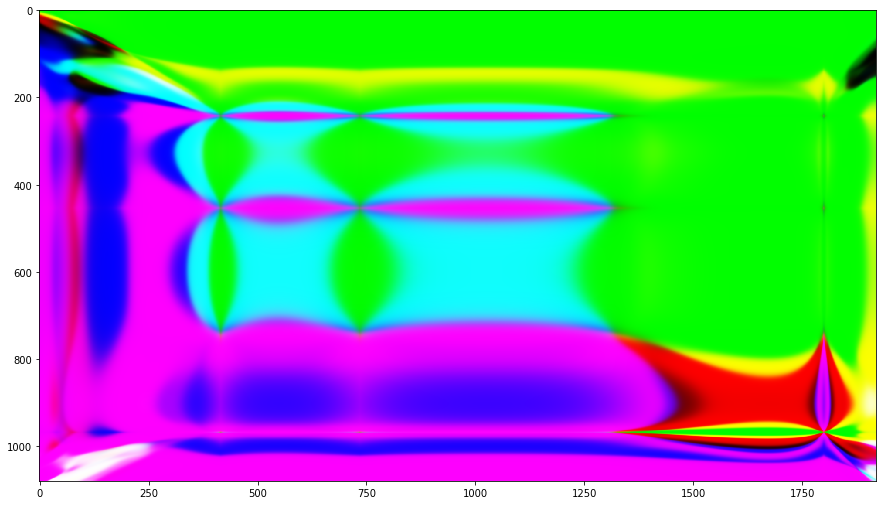

In [11]:
with torch.no_grad():
    xy *= 10
    out = forward(xy, ws1, size_y, size_x, kernel_size=kernel_size)
    plt.figure(figsize=[15]*2)
    plt.imshow(out.detach().cpu().numpy())
    plt.show()

1.141568899154663

In [7]:
xy - torch

tensor([[-2.6879, -2.6879],
        [-2.6597, -2.6879],
        [-2.6316, -2.6879],
        ...,
        [ 2.6316,  2.6879],
        [ 2.6597,  2.6879],
        [ 2.6879,  2.6879]], device='cuda:0')

In [5]:
widths = [spect.shape[0] + 1 if kernel_size else spect.shape[0] + 2] + [8, 8, 8, 3]
ws1 = get_ws(widths, kernel_size=kernel_size)
ws2 = get_ws(widths, kernel_size=kernel_size)
num_weights = sum([w0 * w1 for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:]))])

tensor([[-3.6879, -3.6879],
        [-3.6597, -3.6879],
        [-3.6316, -3.6879],
        ...,
        [ 1.6316,  1.6879],
        [ 1.6597,  1.6879],
        [ 1.6879,  1.6879]], device='cuda:0')

In [18]:
seconds = 3
frame_rate = 15
num_frames = frame_rate * seconds

def get_im(frame_idx, xy_orig):
    with torch.no_grad():
        out = forward(xy_orig / (1 + frame_idx), ws1, size_y, size_x, kernel_size=kernel_size)
    return out.detach().cpu().numpy()

ims = []
for i_frame in tqdm(range(num_frames - 1)):
    im = get_im(i_frame, xy)
    ims.append(im)

100%|██████████| 44/44 [00:00<00:00, 756.95it/s]


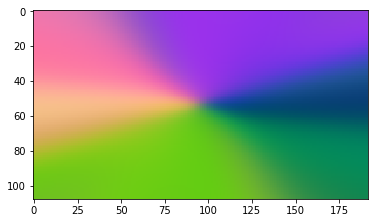

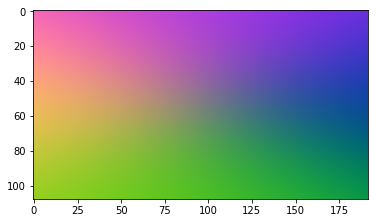

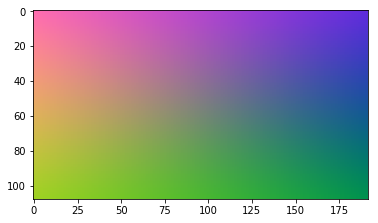

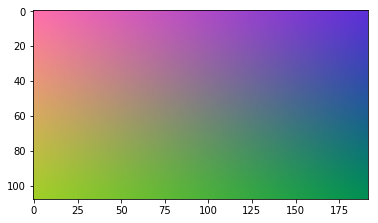

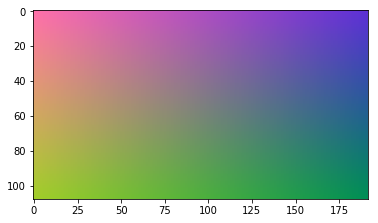

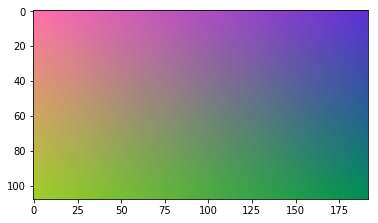

In [19]:
for im in ims[::len(ims)//5]:
    plt.imshow(im)
    plt.show()r

In [8]:
from scipy.io.wavfile import write
write('tmp.wav', sr, np.clip((audio_subset * 32768.), -32768, 32768).astype(np.int16))

In [9]:
import os
import shutil
from skimage.color import hsv2rgb
hsv2rgb = lambda x: x
shutil.rmtree('cool2')
os.makedirs('cool2')
for i, im in tqdm(enumerate(ims)):
    plt.imsave('cool2/im%06d.png' % (i + 1), hsv2rgb(im))

1124it [01:47, 10.41it/s]


In [75]:
ws1 = get_ws(widths)
ws2 = get_ws(widths)

ims = []
num_frames = 200

now = time.time()
for alpha, o_x, o_y in zip(np.linspace(0, 1, num_frames),
                           np.linspace(-1, 1, num_frames),
                           np.linspace(-1, 1, num_frames)):
    ws_this = interp_ws(ws1, ws2, alpha)
    xy = meshgrid(size, o_x, o_y)
    out = forward(xy, ws_this)
    ims.append(out)
    
print (time.time() - now)

4.694384574890137
